In [277]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse
import math
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
import keras
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [3]:
binary_df1 = pd.read_csv('C:\\Users\\Reveal GC\\Desktop\\Hybrid\\Teds_dummies_dataset.csv')

In [3]:
binary_df1.head()

,Unnamed: 0,SEX_A_1.0,SEX_A_2.0,RACE_A_1.0,RACE_A_13.0,RACE_A_2.0,RACE_A_20.0,RACE_A_21.0,RACE_A_23.0,RACE_A_3.0,...,AGE_GROUP_1,AGE_GROUP_2,AGE_GROUP_3,AGE_GROUP_4,AGE_GROUP_5,AGE_GROUP_6,ADMTDATE,AGE_O,SERVICES_A,STATEFIP
0,0,0,1,1,0,0,0,0,0,0,...,0,1,0,0,0,0,2018-10-30,24.0,7.0,AK
1,1,0,1,0,0,0,0,1,0,0,...,0,0,1,0,0,0,2018-05-04,32.0,7.0,AK
2,2,0,1,1,0,0,0,0,0,0,...,0,1,0,0,0,0,2018-10-26,26.0,7.0,AK
3,3,0,1,0,0,0,0,1,0,0,...,1,0,0,0,0,0,2018-12-11,14.0,7.0,AK
4,4,0,1,0,0,0,0,1,0,0,...,0,0,0,0,0,1,2018-08-24,62.0,7.0,AK


In [4]:
binary_df1.drop('Unnamed: 0',axis=1, inplace=True)

In [6]:
def indexeddf(df,freq=None,st=None,agg=None):
    if st is not None:
        ST = df[df['STATEFIP']==st]
        ST['ADMTDATE'] = pd.to_datetime(ST['ADMTDATE'])
        ST = ST.set_index('ADMTDATE')
        ST1 = ST.groupby(pd.Grouper(freq=freq)).agg(agg)
        return ST1
    elif st is None:
        df['ADMTDATE'] = pd.to_datetime(df['ADMTDATE'])
        df = df.set_index('ADMTDATE')
        df1 = df.groupby(pd.Grouper(freq=freq)).agg(agg)
        return df1

In [65]:
df = indexeddf(binary_df1,freq='M',agg='sum')

In [160]:
df.head()

,SEX_A_1.0,SEX_A_2.0,RACE_A_1.0,RACE_A_13.0,RACE_A_2.0,RACE_A_20.0,RACE_A_21.0,RACE_A_23.0,RACE_A_3.0,RACE_A_4.0,...,SERVICES_A_8.0,AGE_GROUP_1,AGE_GROUP_2,AGE_GROUP_3,AGE_GROUP_4,AGE_GROUP_5,AGE_GROUP_6,AGE_O,SERVICES_A,TOTAL_ADMISSIONS
ADMTDATE,,,,,,,,,,,,,,,,,,,,,
2008-01-31,121549,57604,371,1021,3685,16210,1799,728,186,37439,...,2307,14323,58828,41803,43206,17958,3035,6134826.0,985393.0,179153
2008-02-29,110894,51794,345,1020,3631,14705,1670,600,163,33842,...,2190,13258,53383,37912,39168,16190,2777,5564107.0,893284.0,162688
2008-03-31,117005,55591,362,960,3763,15503,1844,624,192,36891,...,2312,13589,56960,40159,41587,17342,2959,5913924.0,946069.0,172596
2008-04-30,121698,59604,347,1038,3821,15980,1941,648,183,40089,...,2389,14353,59975,41637,43633,18606,3098,6215864.0,1001564.0,181302
2008-05-31,111023,53314,350,861,3585,14622,1853,528,173,35495,...,2101,12520,54313,37554,39916,16993,3041,5657000.0,888466.0,164337


# <center>Forecasting Total admissions to Substance Abuse Treatment Facilities using LSTM architecture 

# <center> Recap: 

### <font color='#D1AA0A'> ** Substance abuse is a major problem in the US and costs tax-payers millions of dollars a year.

### <font color='#D1AA0A'>** Using the Treatment Episode Dataset for years 2008-2018, can total admissions into substance abuse treatment facilities be accurately forecasted?

### <font color='#D1AA0A'>** Treatment is less expensive than alternatives like imprisoning a person with addiction.  It would behoove policy makers to allocate the proper amount of resources to deal with the problem


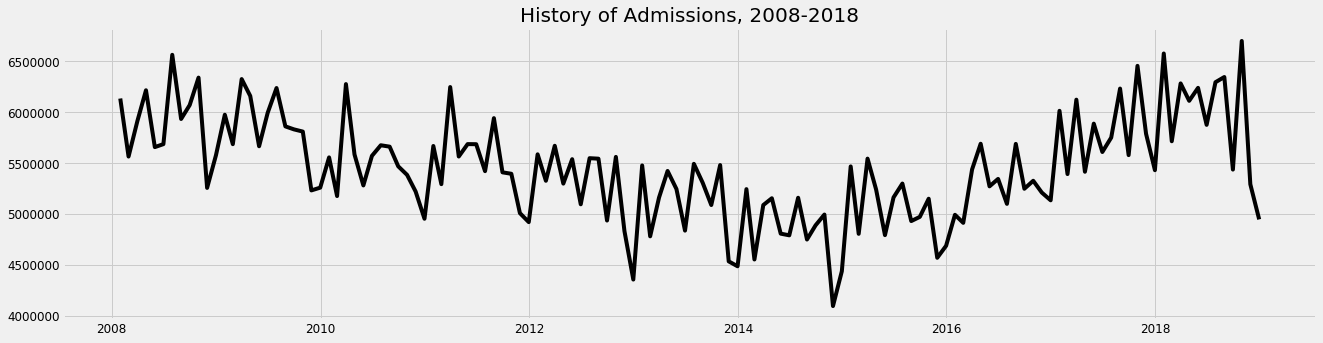

In [279]:
plt.figure(figsize=(20,5))
plt.plot(df['AGE_O'],color='black',linewidth=4.0)
plt.title('History of Admissions, 2008-2018',fontsize=20)
plt.show()

In [292]:
plt.style.use('fivethirtyeight')
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

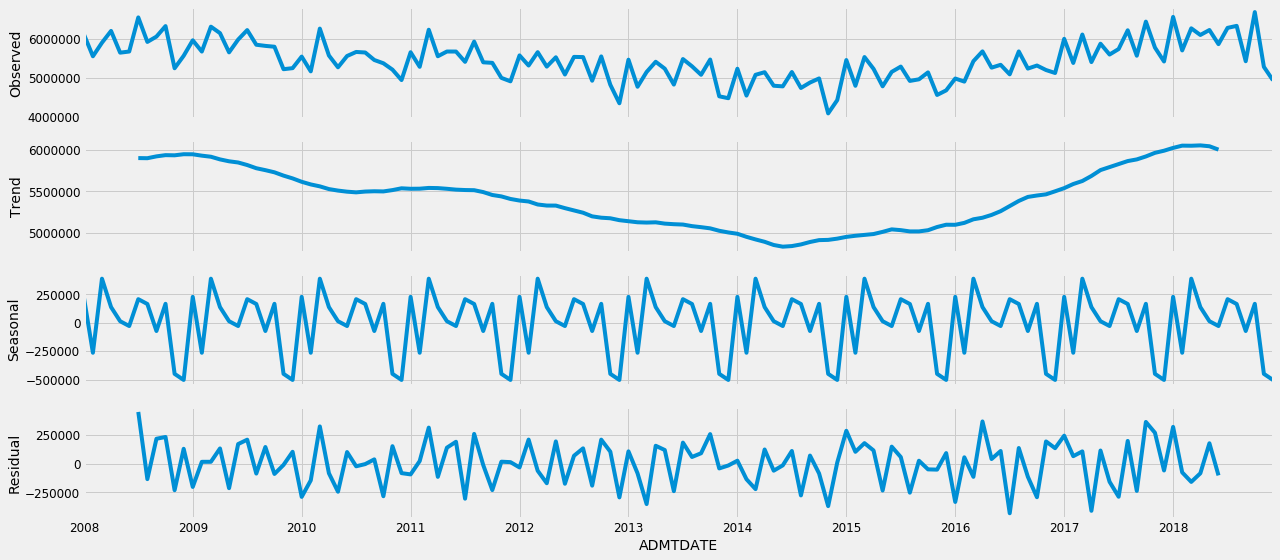

In [293]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(df['AGE_O'], model='additive')
fig = decomposition.plot()
plt.show()

# Auto Regressive Integrated Moving Average (ARIMA)

In [161]:
from statsmodels.tsa.arima_model import ARIMA

In [162]:
df_adm = pd.DataFrame(df['TOTAL_ADMISSIONS'])

In [163]:
train, test = pd.DataFrame(df_adm[:-12]),pd.DataFrame(df_adm[-12:])

In [164]:
scaler = MinMaxScaler()
train = scaler.fit_transform(train)
test = scaler.transform(test)

In [165]:
import itertools
p=d=q=range(0,5)
pdq = list(itertools.product(p,d,q))

In [166]:
import warnings
warnings.filterwarnings('ignore')
results = {}
for param in pdq:
    try:
        model_arima = ARIMA(train,order=param)
        model_arima_fit = model_arima.fit()
        results[param] = param
        results[param] = model_arima_fit.aic
    except:
        continue

In [167]:
min_val = min(results.keys(),key=(lambda k: results[k]))

In [168]:
model_arima = ARIMA(train,order=(min_val))
model_arima_fit = model_arima.fit()

In [171]:
predictions = model_arima_fit.forecast(steps=12)[0]
predictions

array([0.74256538, 0.60120615, 0.61990201, 0.67705602, 0.51923263,
       0.56769126, 0.62880909, 0.61904504, 0.6608831 , 0.61000759,
       0.54810307, 0.56922886])

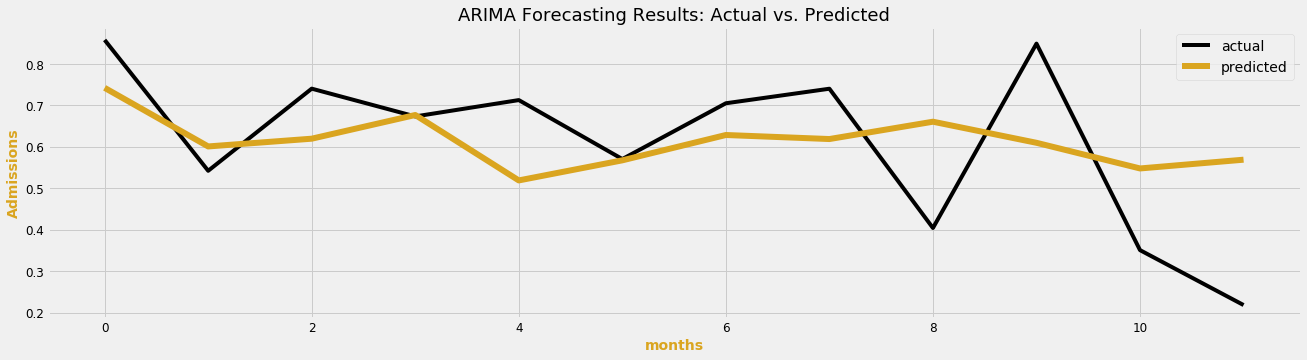

In [294]:
plt.figure(figsize=(20,5))
plt.plot(test,color='black',linewidth=4.0, label='actual')
plt.plot(predictions,color='goldenrod',linewidth=6.0, label='predicted')
plt.title('ARIMA Forecasting Results: Actual vs. Predicted',fontsize=18)
plt.legend()
plt.xlabel('months',fontsize=14,color='goldenrod',fontweight='bold')
plt.ylabel('Admissions',fontsize=14,color='goldenrod',fontweight='bold')
plt.show()

In [176]:
mse_result = mse(test,predictions)

In [298]:
print('Root Square Mean Error: {}'.format(math.sqrt(mse_result)))

Root Square Mean Error: 0.1766211443628991


# Univariate LSTM Time Series Analysis

In [71]:
df['TOTAL_ADMISSIONS'] = df['SEX_A_1.0'] + df['SEX_A_2.0']

In [72]:
df_adm = pd.DataFrame(df['TOTAL_ADMISSIONS'])

In [180]:
train, test = pd.DataFrame(df_adm[:-12]),pd.DataFrame(df_adm[-12:])

In [181]:
train

,TOTAL_ADMISSIONS
ADMTDATE,
2008-01-31,179153
2008-02-29,162688
2008-03-31,172596
2008-04-30,181302
2008-05-31,164337
...,...
2017-08-31,171276
2017-09-30,153016
2017-10-31,176730


In [182]:
scaler = MinMaxScaler()
train = scaler.fit_transform(train)
test = scaler.transform(test)

In [201]:
n_input = 12
n_features = 1

generator = TimeseriesGenerator(train,train, length=n_input, batch_size=6)

In [248]:
keras.backend.clear_session()

In [249]:
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_input, n_features)))
model.add(Dropout(0.15))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

history_lstm = model.fit_generator(generator, epochs=100)

Epoch 1/100
18/18 [==============================] - 0s 27ms/step - loss: 0.1002
Epoch 2/100
18/18 [==============================] - 0s 13ms/step - loss: 0.0256
Epoch 3/100
18/18 [==============================] - 0s 12ms/step - loss: 0.0222
Epoch 4/100
18/18 [==============================] - 0s 13ms/step - loss: 0.0223
Epoch 5/100
18/18 [==============================] - 0s 13ms/step - loss: 0.0221
Epoch 6/100
18/18 [==============================] - 0s 12ms/step - loss: 0.0202
Epoch 7/100
18/18 [==============================] - 0s 12ms/step - loss: 0.0221
Epoch 8/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0224
Epoch 9/100
18/18 [==============================] - 0s 10ms/step - loss: 0.0227
Epoch 10/100
18/18 [==============================] - 0s 11ms/step - loss: 0.0201
Epoch 11/100
18/18 [==============================] - 0s 13ms/step - loss: 0.0204
Epoch 12/100
18/18 [==============================] - 0s 12ms/step - loss: 0.0218
Epoch 13/100
18/18 [=====

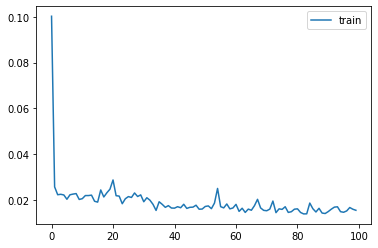

In [250]:
plt.plot(history_lstm.history['loss'],label='train')
#plt.plot(history_lstm.history['val_loss'],label='test')
plt.legend()
plt.show()

In [251]:
pred_list = []

batch = train[-n_input:].reshape((1, n_input, n_features))

for i in range(n_input):
    pred_list.append(model.predict(batch)[0])
    batch = np.append(batch[:, 1:, :], [[pred_list[i]]],axis=1)

In [252]:
df_predict = pd.DataFrame(pred_list, index=df_adm[-n_input:].index, columns=['Predictions'])

#df_test = pd.concat([pd.DataFrame(test), df_predict],axis=1)

In [253]:
df_test = pd.DataFrame(test,columns=['test'])

In [254]:
df_test['pred'] = pred_list

In [255]:
df_test.head()

,test,pred
0,0.858114,[0.59530115]
1,0.542469,[0.5063194]
2,0.740607,[0.6124514]
3,0.673611,[0.50445724]
4,0.713043,[0.5673997]


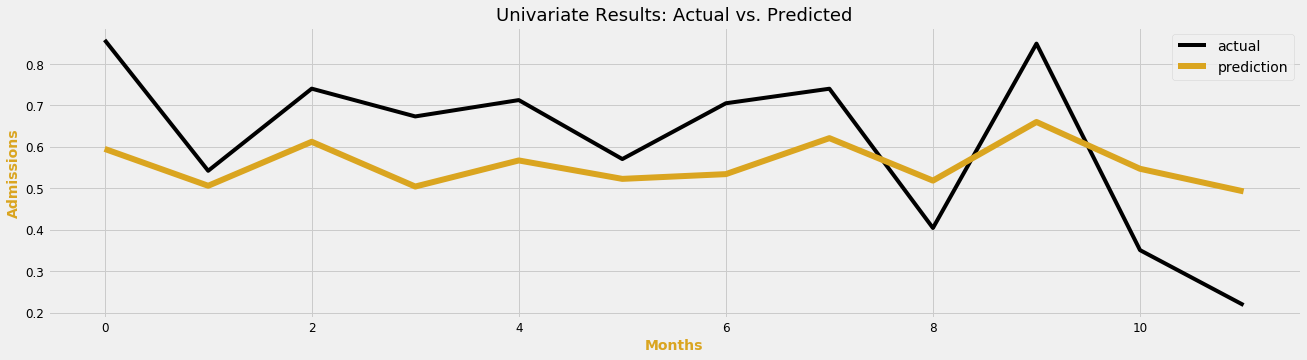

In [295]:
plt.figure(figsize=(20,5))
plt.plot(df_test.index, df_test['test'], label = 'actual',color='black',linewidth=4.0)
plt.plot(df_test.index,df_test['pred'], label= 'prediction',color='goldenrod',linewidth=6.0)
plt.title('Univariate Results: Actual vs. Predicted',fontsize=18)
plt.xlabel('Months',fontsize=14,color='goldenrod',fontweight='bold')
plt.ylabel('Admissions',fontsize=14,color='goldenrod',fontweight='bold')
plt.legend()
plt.show()

In [260]:
print('Root Mean-Square Error: {}'.format(round(np.sqrt(mse(df_test['test'],df_test['pred'])),6)))

Root Mean-Square Error: 0.169523


In [198]:
df_adm = pd.DataFrame(df['TOTAL_ADMISSIONS'])

# <center>Multi-Step Multivariate Time Series Forecasting

# <font color='#D1AA0A'><center> Learning from Label Proportions 
    
### <font color='#D1AA0A'><center> a Novel Approach in Time Series Analysis


 
 Step 1 : Handle null values by imputation and dropping beyond a set threshold

 

 Step 2 : Select features to use in model:
    
    SEX
    SERVICES
    AGE
    RACE

  Step 3 : Transform Age into Categorical variable

  Aggregate data by month and use proportion of each class in each feature of total admissions for that month as input variables.

In [38]:
df2 = df

In [39]:
df2.head()

,SEX_A_1.0,SEX_A_2.0,RACE_A_1.0,RACE_A_13.0,RACE_A_2.0,RACE_A_20.0,RACE_A_21.0,RACE_A_23.0,RACE_A_3.0,RACE_A_4.0,...,SERVICES_A_8.0,AGE_GROUP_1,AGE_GROUP_2,AGE_GROUP_3,AGE_GROUP_4,AGE_GROUP_5,AGE_GROUP_6,AGE_O,SERVICES_A,TOTAL_ADMISSIONS
ADMTDATE,,,,,,,,,,,,,,,,,,,,,
2008-01-31,121549,57604,371,1021,3685,16210,1799,728,186,37439,...,2307,14323,58828,41803,43206,17958,3035,6134826.0,985393.0,179153
2008-02-29,110894,51794,345,1020,3631,14705,1670,600,163,33842,...,2190,13258,53383,37912,39168,16190,2777,5564107.0,893284.0,162688
2008-03-31,117005,55591,362,960,3763,15503,1844,624,192,36891,...,2312,13589,56960,40159,41587,17342,2959,5913924.0,946069.0,172596
2008-04-30,121698,59604,347,1038,3821,15980,1941,648,183,40089,...,2389,14353,59975,41637,43633,18606,3098,6215864.0,1001564.0,181302
2008-05-31,111023,53314,350,861,3585,14622,1853,528,173,35495,...,2101,12520,54313,37554,39916,16993,3041,5657000.0,888466.0,164337


In [40]:
for col in df2.columns:
    if 'TOTAL' not in col:
        df2[col] = df2[col]/df2['TOTAL_ADMISSIONS']

In [41]:
df2.drop('SERVICES_A',axis=1,inplace=True)

In [62]:
df2.head()

,SEX_A_1.0,SEX_A_2.0,RACE_A_1.0,RACE_A_13.0,RACE_A_2.0,RACE_A_20.0,RACE_A_21.0,RACE_A_23.0,RACE_A_3.0,RACE_A_4.0,...,SERVICES_A_6.0,SERVICES_A_7.0,SERVICES_A_8.0,AGE_GROUP_1,AGE_GROUP_2,AGE_GROUP_3,AGE_GROUP_4,AGE_GROUP_5,AGE_GROUP_6,TOTAL_ADMISSIONS
ADMTDATE,,,,,,,,,,,,,,,,,,,,,
2008-01-31,0.678465,0.321535,0.002071,0.005699,0.020569,0.090481,0.010042,0.004064,0.001038,0.208978,...,0.110944,0.515543,0.012877,0.079948,0.328367,0.233337,0.241168,0.100238,0.016941,179153
2008-02-29,0.681636,0.318364,0.002121,0.006270,0.022319,0.090388,0.010265,0.003688,0.001002,0.208018,...,0.106806,0.517242,0.013461,0.081493,0.328131,0.233035,0.240755,0.099516,0.017069,162688
2008-03-31,0.677913,0.322087,0.002097,0.005562,0.021802,0.089822,0.010684,0.003615,0.001112,0.213742,...,0.108514,0.516912,0.013395,0.078733,0.330019,0.232676,0.240950,0.100477,0.017144,172596
2008-04-30,0.671245,0.328755,0.001914,0.005725,0.021075,0.088140,0.010706,0.003574,0.001009,0.221117,...,0.109111,0.525069,0.013177,0.079166,0.330802,0.229655,0.240665,0.102624,0.017088,181302
2008-05-31,0.675581,0.324419,0.002130,0.005239,0.021815,0.088976,0.011276,0.003213,0.001053,0.215989,...,0.105965,0.500466,0.012785,0.076185,0.330498,0.228518,0.242891,0.103403,0.018505,164337


In [43]:
df2.drop('AGE_O',axis=1,inplace=True)

In [299]:
values = df2.values
values = values.astype('float32')
scaler = MinMaxScaler()
scaled = scaler.fit_transform(values)

In [300]:
from pandas import DataFrame
from pandas import concat
 
def series_to_supervised(data, in=1, out=1, dropnan=True):
    var = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    
    for i in range(in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(var)]
    for i in range(0, out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(var)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(var)]
    
    agg = concat(cols, axis=1)
    agg.columns = names
    
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [325]:
df3 = series_to_supervised(scaled,1,1)

In [326]:
pd.options.display.max_columns=999

In [327]:
df3.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var11(t-1),var12(t-1),var13(t-1),var14(t-1),var15(t-1),var16(t-1),var17(t-1),var18(t-1),var19(t-1),var20(t-1),var21(t-1),var22(t-1),var23(t-1),var24(t-1),var25(t-1),var26(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t),var9(t),var10(t),var11(t),var12(t),var13(t),var14(t),var15(t),var16(t),var17(t),var18(t),var19(t),var20(t),var21(t),var22(t),var23(t),var24(t),var25(t),var26(t)
1,0.864392,0.135608,0.410386,0.222660,0.059689,1.000000,0.029272,0.257584,0.853849,0.774305,0.215521,0.608850,0.120399,0.370110,0.478208,0.914368,0.146122,0.563680,0.185290,0.972282,0.700853,0.120883,0.969739,0.012995,0.000000,0.852922,0.929024,0.070977,0.438283,0.420200,0.251589,0.996245,0.042202,0.174234,0.821180,0.756456,0.191961,0.522846,0.199229,0.281102,0.492788,0.782574,0.024666,0.581095,0.204261,1.000000,0.697789,0.117496,0.963740,0.000000,0.003897,0.632613
2,0.929024,0.070977,0.438283,0.420200,0.251589,0.996245,0.042202,0.174234,0.821180,0.756456,0.191961,0.522846,0.199229,0.281102,0.492788,0.782574,0.024666,0.581095,0.204261,1.000000,0.697789,0.117496,0.963740,0.000000,0.003897,0.632613,0.853139,0.146861,0.425256,0.175261,0.194951,0.973564,0.066450,0.158106,0.920631,0.862879,0.100733,0.618350,0.218313,0.299377,0.369832,0.650954,0.074786,0.577721,0.202121,0.950476,0.722277,0.113472,0.966568,0.017294,0.006156,0.765187
3,0.853139,0.146861,0.425256,0.175261,0.194951,0.973564,0.066450,0.158106,0.920631,0.862879,0.100733,0.618350,0.218313,0.299377,0.369832,0.650954,0.074786,0.577721,0.202121,0.950476,0.722277,0.113472,0.966568,0.017294,0.006156,0.765187,0.717245,0.282756,0.322425,0.231734,0.115217,0.906065,0.067723,0.148955,0.827883,1.000000,0.000000,0.494980,0.159756,0.283960,0.260556,0.706909,0.092313,0.661324,0.195023,0.958249,0.732425,0.079582,0.962424,0.055900,0.004443,0.881677
4,0.717245,0.282756,0.322425,0.231734,0.115217,0.906065,0.067723,0.148955,0.827883,1.000000,0.000000,0.494980,0.159756,0.283960,0.260556,0.706909,0.092313,0.661324,0.195023,0.958249,0.732425,0.079582,0.962424,0.055900,0.004443,0.881677,0.805626,0.194374,0.443410,0.063484,0.196330,0.939588,0.100705,0.068776,0.866895,0.904658,0.074586,0.635418,0.363793,0.352161,0.468614,0.970039,0.000000,0.409138,0.182284,0.904761,0.728482,0.066823,0.994776,0.069908,0.047367,0.654678
5,0.805626,0.194374,0.443410,0.063484,0.196330,0.939588,0.100705,0.068776,0.866895,0.904658,0.074586,0.635418,0.363793,0.352161,0.468614,0.970039,0.000000,0.409138,0.182284,0.904761,0.728482,0.066823,0.994776,0.069908,0.047367,0.654678,0.808959,0.191041,0.376998,0.237602,0.212920,0.904035,0.083947,0.013814,0.810863,0.890814,0.109969,0.627585,0.251961,0.334251,0.461671,0.877107,0.370059,0.384217,0.199456,0.836318,0.753202,0.051384,1.000000,0.117635,0.055588,0.657809


In [328]:
names = [x for x in df3.columns if '(t)' in x]

In [331]:
names

['var1(t)',
 'var2(t)',
 'var3(t)',
 'var4(t)',
 'var5(t)',
 'var6(t)',
 'var7(t)',
 'var8(t)',
 'var9(t)',
 'var10(t)',
 'var11(t)',
 'var12(t)',
 'var13(t)',
 'var14(t)',
 'var15(t)',
 'var16(t)',
 'var17(t)',
 'var18(t)',
 'var19(t)',
 'var20(t)',
 'var21(t)',
 'var22(t)',
 'var23(t)',
 'var24(t)',
 'var25(t)']

In [330]:
names = names[:-1]

In [332]:
df3.drop(names,axis=1,inplace=True)

In [333]:
df3.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var11(t-1),var12(t-1),var13(t-1),var14(t-1),var15(t-1),var16(t-1),var17(t-1),var18(t-1),var19(t-1),var20(t-1),var21(t-1),var22(t-1),var23(t-1),var24(t-1),var25(t-1),var26(t-1),var26(t)
1,0.864392,0.135608,0.410386,0.222660,0.059689,1.000000,0.029272,0.257584,0.853849,0.774305,0.215521,0.608850,0.120399,0.370110,0.478208,0.914368,0.146122,0.563680,0.185290,0.972282,0.700853,0.120883,0.969739,0.012995,0.000000,0.852922,0.632613
2,0.929024,0.070977,0.438283,0.420200,0.251589,0.996245,0.042202,0.174234,0.821180,0.756456,0.191961,0.522846,0.199229,0.281102,0.492788,0.782574,0.024666,0.581095,0.204261,1.000000,0.697789,0.117496,0.963740,0.000000,0.003897,0.632613,0.765187
3,0.853139,0.146861,0.425256,0.175261,0.194951,0.973564,0.066450,0.158106,0.920631,0.862879,0.100733,0.618350,0.218313,0.299377,0.369832,0.650954,0.074786,0.577721,0.202121,0.950476,0.722277,0.113472,0.966568,0.017294,0.006156,0.765187,0.881677
4,0.717245,0.282756,0.322425,0.231734,0.115217,0.906065,0.067723,0.148955,0.827883,1.000000,0.000000,0.494980,0.159756,0.283960,0.260556,0.706909,0.092313,0.661324,0.195023,0.958249,0.732425,0.079582,0.962424,0.055900,0.004443,0.881677,0.654678
5,0.805626,0.194374,0.443410,0.063484,0.196330,0.939588,0.100705,0.068776,0.866895,0.904658,0.074586,0.635418,0.363793,0.352161,0.468614,0.970039,0.000000,0.409138,0.182284,0.904761,0.728482,0.066823,0.994776,0.069908,0.047367,0.654678,0.657809


In [334]:
df3.drop('var26(t-1)',axis=1,inplace=True)

In [335]:
# split into train and test sets
values = df3.values
n_train = 118
train = values[:n_train, :]
test = values[n_train:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(118, 1, 25) (118,) (13, 1, 25) (13,)


Train on 118 samples, validate on 13 samples
Epoch 1/500
 - 0s - loss: 0.5824 - val_loss: 0.6609
Epoch 2/500
 - 0s - loss: 0.5214 - val_loss: 0.6091
Epoch 3/500
 - 0s - loss: 0.4618 - val_loss: 0.5573
Epoch 4/500
 - 0s - loss: 0.4034 - val_loss: 0.5053
Epoch 5/500
 - 0s - loss: 0.3475 - val_loss: 0.4535
Epoch 6/500
 - 0s - loss: 0.2974 - val_loss: 0.4019
Epoch 7/500
 - 0s - loss: 0.2533 - val_loss: 0.3559
Epoch 8/500
 - 0s - loss: 0.2184 - val_loss: 0.3157
Epoch 9/500
 - 0s - loss: 0.1939 - val_loss: 0.2800
Epoch 10/500
 - 0s - loss: 0.1809 - val_loss: 0.2504
Epoch 11/500
 - 0s - loss: 0.1730 - val_loss: 0.2298
Epoch 12/500
 - 0s - loss: 0.1682 - val_loss: 0.2191
Epoch 13/500
 - 0s - loss: 0.1689 - val_loss: 0.2154
Epoch 14/500
 - 0s - loss: 0.1693 - val_loss: 0.2151
Epoch 15/500
 - 0s - loss: 0.1675 - val_loss: 0.2176
Epoch 16/500
 - 0s - loss: 0.1639 - val_loss: 0.2233
Epoch 17/500
 - 0s - loss: 0.1597 - val_loss: 0.2335
Epoch 18/500
 - 0s - loss: 0.1553 - val_loss: 0.2460
Epoch 19/5

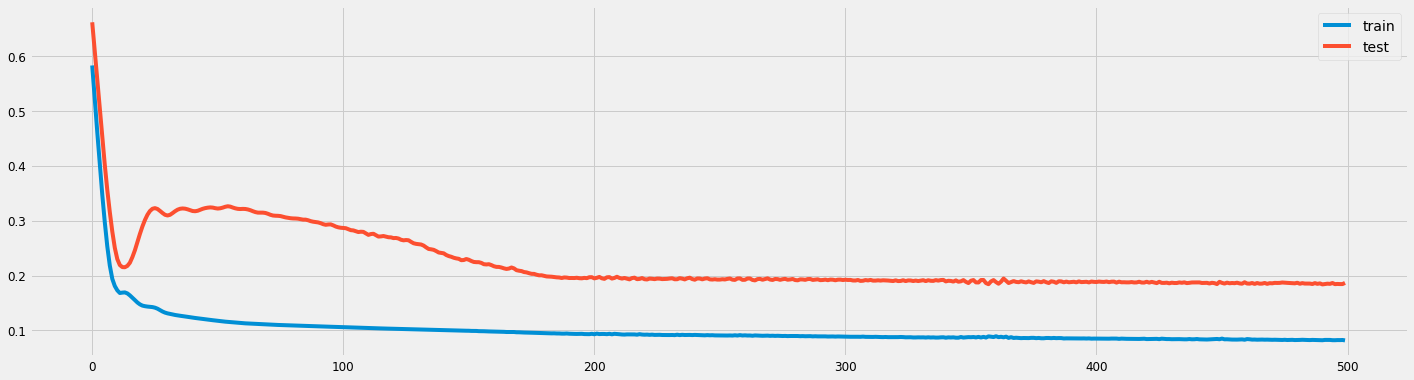

In [336]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=500, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.figure(figsize=(22,6))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [337]:
df1 = pd.DataFrame()

In [338]:
df1['actual'] = test_y
df1['pred'] = yhat

In [339]:
df1

,actual,pred
0,0.432335,0.437712
1,0.858114,0.773395
2,0.542470,0.528287
3,0.740607,0.615941
4,0.673611,0.610120
5,0.713043,0.605775
6,0.570769,0.493078
7,0.705363,0.515478
8,0.740446,0.556190
9,0.404450,0.429621


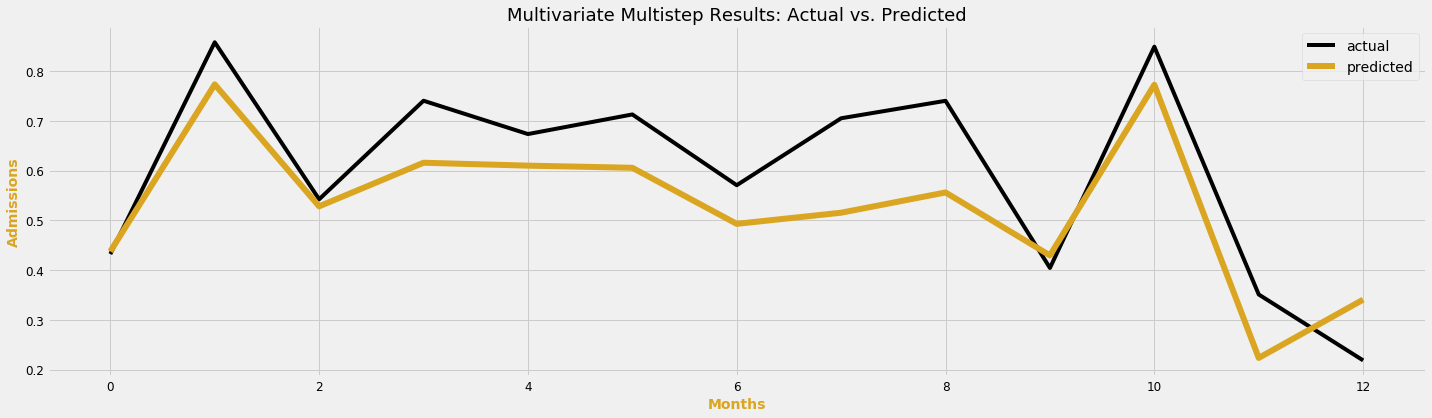

In [340]:
plt.figure(figsize=(22,6))
plt.plot(df1['actual'],label='actual',color='black',linewidth=4.0)
plt.plot(df1['pred'],label='predicted',color='goldenrod',linewidth=6.0)
plt.title('Multivariate Multistep Results: Actual vs. Predicted',fontsize=18)
plt.xlabel('Months',fontsize=14,color='goldenrod',fontweight='bold')
plt.ylabel('Admissions',fontsize=14,color='goldenrod',fontweight='bold')
plt.legend()
plt.show()

In [341]:
print('Root Mean-Square Error: {}'.format(round(np.sqrt(mse(df1['actual'],df1['pred'])),2)))

Root Mean-Square Error: 0.10999999940395355


## <center> Conclusion:

If policy makers have a good idea of the proportion of male and female, black or white and the proportion of age groups and services rendered for a previous point in time, they can better predict and allocate resources for future services better than if they used a univariate model.

Citations: 
https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

Cui, L., Zhang, J., Chen, Z., Shi, Y., & Yu, P. S. (2017). Inverse extreme learning machine for learning with label proportions. 2017 IEEE International Conference on Big Data (Big Data), Big Data (Big Data), 2017 IEEE International Conference On, 576–585. https://doi-org.proxy-bc.researchport.umd.edu/10.1109/BigData.2017.8257973